In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt

import gc
import time
from datetime import timedelta


from VGG import VGG
from utils import count_trainable_parameters, count_total_parameters
from utils import clear_gpu_memory, get_gpu_memory
from utils import plot_metrics, create_summary_table
from utils import get_device, get_dataloaders
from utils import train_one_epoch, evaluate

In [2]:
def load_dataset_metrics(dataset):
    metrics = {
        'train_acc': {},
        'test_acc': {},
        'train_loss': {},
        'test_loss': {},
    }
    for arch in architectures:
        for mode in modes:
            filename = f"{dataset}_{arch}_{mode}_metrics.csv"
            path = os.path.join(results_dir, filename)
            if os.path.exists(path):
                df = pd.read_csv(path)
                label = f"{arch}_{mode}"
                metrics['train_acc'][label] = df['train_acc']
                metrics['test_acc'][label] = df['test_acc']
                metrics['train_loss'][label] = df['train_loss']
                metrics['test_loss'][label] = df['test_loss']
    return metrics


In [3]:
def get_model(arch, num_classes, device, dataset='cifar10', pretrained=False):
    model = VGG(arch, num_classes=num_classes, dataset=dataset)
    return model.to(device)


In [4]:
device = get_device()
print(f'device - {device}')

architectures = ['vgg16', 'vgg19']
modes = ['scratch']  
# modes = ['scratch', 'transfer']  

# batch_size = 8
batch_size = 128
results_dir = 'vgg_results'
os.makedirs(results_dir, exist_ok=True)

clear_gpu_memory()
get_gpu_memory()


epochs = 20
dataset_name = "mnist"
trainloader, testloader, num_classes = get_dataloaders(dataset_name, batch_size)


device - cuda
GPU memory allocated: 0.00 GB
GPU memory reserved: 0.00 GB


In [12]:

for arch in architectures:
    for mode in modes:
        use_pretrained = (mode == 'transfer')

        print(f"\n{mode.title()} learning: {arch} on {dataset_name}...")
        print("="*50)

        total_train_time = 0
        total_eval_time = 0
        start_time = time.time()

        #  get_model(arch, num_classes, device, dataset='cifar10', pretrained=False):
        model = get_model(arch, num_classes, device, dataset=dataset_name, pretrained=use_pretrained)
        criterion = nn.CrossEntropyLoss()
            
        optimizer = optim.SGD(
            model.parameters(),
            lr=0.01,
            momentum=0.9,
            weight_decay=5e-4
        )

        trainable = count_trainable_parameters(model)
        total = count_total_parameters(model)
        print(f"Trainable parameters: {trainable:,}")
        print(f"Total parameters: {total:,}")
        print(f"Percentage trainable: {trainable/total:.2%}")

        history = []
        for epoch in range(1, epochs + 1):
            epoch_start = time.time()
            
            train_start = time.time()
            train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, device)
            train_time = time.time() - train_start
            
            eval_start = time.time()
            test_loss, test_acc = evaluate(model, testloader, criterion, device)
            eval_time = time.time() - eval_start
            
            total_train_time += train_time
            total_eval_time += eval_time
            epoch_time = time.time() - epoch_start
            
            print(f"Epoch {epoch}/{epochs} - "
                  f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, "
                  f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
            print(f"Epoch time: {timedelta(seconds=epoch_time)} "
                  f"(Train: {timedelta(seconds=train_time)}, "
                  f"Eval: {timedelta(seconds=eval_time)}")
                
            history.append({
                'epoch': epoch,
                'train_loss': train_loss,
                'train_acc': train_acc,
                'test_loss': test_loss,
                'test_acc': test_acc,
                'train_time': train_time,
                'eval_time': eval_time,
                'epoch_time': epoch_time
            })


        total_time = time.time() - start_time
        avg_epoch_time = total_time / epochs
        avg_train_time = total_train_time / epochs
        avg_eval_time = total_eval_time / epochs
        
        print("\nTraining Summary:")
        print(f"Total training time: {timedelta(seconds=total_time)}")
        print(f"Average epoch time: {timedelta(seconds=avg_epoch_time)}")
        print(f"Average training time per epoch: {timedelta(seconds=avg_train_time)}")
        print(f"Average evaluation time per epoch: {timedelta(seconds=avg_eval_time)}")
        print(f"Total training time (excluding eval): {timedelta(seconds=total_train_time)}")
        print(f"Total evaluation time: {timedelta(seconds=total_eval_time)}")
            
        # save metrics with timing information
        csv_name = f"{dataset_name}_{arch}_{mode}_metrics.csv"
        df = pd.DataFrame(history)
        df.to_csv(os.path.join(results_dir, csv_name), index=False)
        print(f"\nSaved metrics to {results_dir}/{csv_name}")

        # save model
        model_filename = f"{dataset_name}_{arch}_{mode}_model.pth"
        model_path = os.path.join(results_dir, model_filename)
        torch.save(model.state_dict(), model_path)
        print(f"Saved model weights to {model_path}")

        clear_gpu_memory()
        get_gpu_memory()


Scratch learning: vgg16 on mnist...
Trainable parameters: 14,728,266
Total parameters: 14,728,266
Percentage trainable: 100.00%
Epoch 1/20 - Train loss: 0.0961, Train acc: 0.9734, Test loss: 0.0389, Test acc: 0.9876
Epoch time: 0:00:14.984778 (Train: 0:00:13.681504, Eval: 0:00:01.303273
Epoch 2/20 - Train loss: 0.0299, Train acc: 0.9911, Test loss: 0.0212, Test acc: 0.9932
Epoch time: 0:00:14.909550 (Train: 0:00:13.605977, Eval: 0:00:01.303571
Epoch 3/20 - Train loss: 0.0186, Train acc: 0.9943, Test loss: 0.0345, Test acc: 0.9897
Epoch time: 0:00:14.908434 (Train: 0:00:13.608931, Eval: 0:00:01.299502
Epoch 4/20 - Train loss: 0.0142, Train acc: 0.9957, Test loss: 0.0188, Test acc: 0.9946
Epoch time: 0:00:14.913054 (Train: 0:00:13.611465, Eval: 0:00:01.301588
Epoch 5/20 - Train loss: 0.0107, Train acc: 0.9971, Test loss: 0.0152, Test acc: 0.9951
Epoch time: 0:00:14.922694 (Train: 0:00:13.621565, Eval: 0:00:01.301127
Epoch 6/20 - Train loss: 0.0075, Train acc: 0.9979, Test loss: 0.0172, 

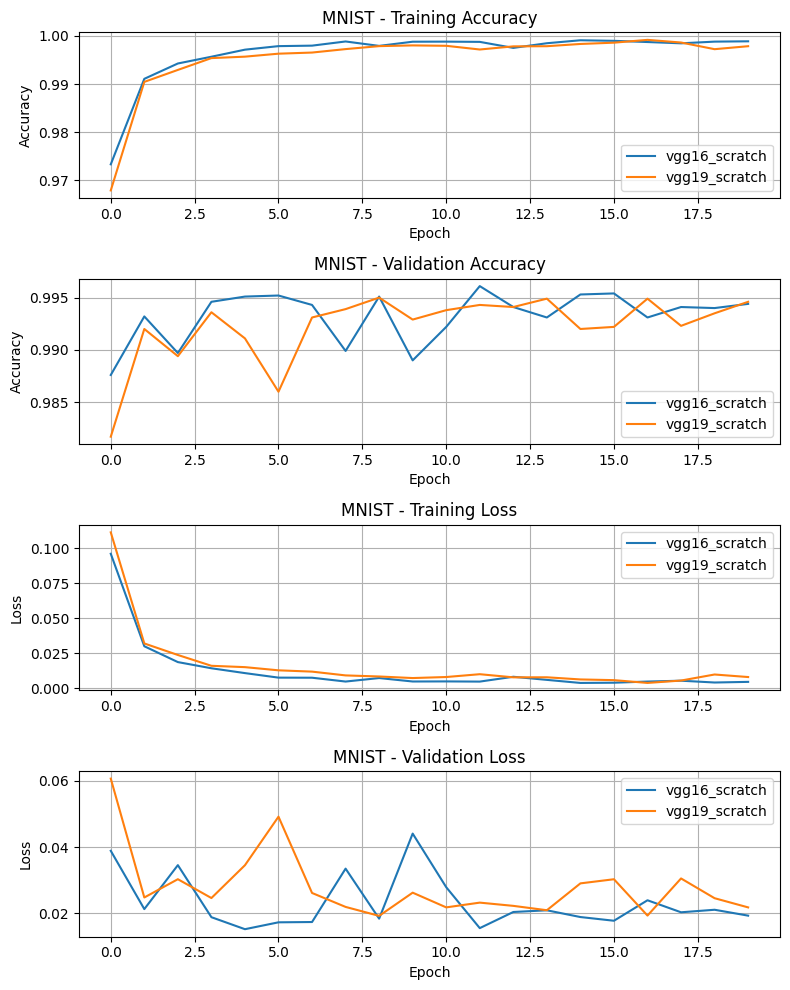

In [13]:
epochs = 20
dataset_name = "mnist"
metrics = load_dataset_metrics(dataset_name)
plot_metrics(metrics, dataset_name, range(epochs))


In [14]:

summary_df = create_summary_table(dataset_name=dataset_name, 
                                  architectures=architectures,
                                 modes=modes,
                                 results_dir=results_dir)
print(summary_df.to_string(index=False))

Dataset Model    Mode  Final Train Acc  Final Test Acc  Final Test Loss  Best Epoch  Best Test Acc
  MNIST vgg16 scratch           0.9989          0.9944           0.0193          12         0.9961
  MNIST vgg19 scratch           0.9978          0.9946           0.0217           9         0.9950


## cifar10

In [5]:
epochs = 20
dataset_name = "cifar10"
trainloader, testloader, num_classes = get_dataloaders(dataset_name, batch_size)

for arch in architectures:
    for mode in modes:
        use_pretrained = (mode == 'transfer')

        print(f"\n{mode.title()} learning: {arch} on {dataset_name}...")
        print("="*50)

        total_train_time = 0
        total_eval_time = 0
        start_time = time.time()
            
        model = get_model(arch, num_classes, device, dataset=dataset_name, pretrained=use_pretrained)
        criterion = nn.CrossEntropyLoss()
            
        optimizer = optim.SGD(
            model.parameters(),
            lr=0.01,
            momentum=0.9,
            weight_decay=5e-4
        )

        trainable = count_trainable_parameters(model)
        total = count_total_parameters(model)
        print(f"Trainable parameters: {trainable:,}")
        print(f"Total parameters: {total:,}")
        print(f"Percentage trainable: {trainable/total:.2%}")

        history = []
        for epoch in range(1, epochs + 1):
            epoch_start = time.time()
            
            train_start = time.time()
            train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, device)
            train_time = time.time() - train_start
            
            eval_start = time.time()
            test_loss, test_acc = evaluate(model, testloader, criterion, device)
            eval_time = time.time() - eval_start
            
            total_train_time += train_time
            total_eval_time += eval_time
            epoch_time = time.time() - epoch_start
            
            print(f"Epoch {epoch}/{epochs} - "
                  f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, "
                  f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
            print(f"Epoch time: {timedelta(seconds=epoch_time)} "
                  f"(Train: {timedelta(seconds=train_time)}, "
                  f"Eval: {timedelta(seconds=eval_time)}")
                
            history.append({
                'epoch': epoch,
                'train_loss': train_loss,
                'train_acc': train_acc,
                'test_loss': test_loss,
                'test_acc': test_acc,
                'train_time': train_time,
                'eval_time': eval_time,
                'epoch_time': epoch_time
            })


        total_time = time.time() - start_time
        avg_epoch_time = total_time / epochs
        avg_train_time = total_train_time / epochs
        avg_eval_time = total_eval_time / epochs
        
        print("\nTraining Summary:")
        print(f"Total training time: {timedelta(seconds=total_time)}")
        print(f"Average epoch time: {timedelta(seconds=avg_epoch_time)}")
        print(f"Average training time per epoch: {timedelta(seconds=avg_train_time)}")
        print(f"Average evaluation time per epoch: {timedelta(seconds=avg_eval_time)}")
        print(f"Total training time (excluding eval): {timedelta(seconds=total_train_time)}")
        print(f"Total evaluation time: {timedelta(seconds=total_eval_time)}")
            
        # save metrics with timing information
        csv_name = f"{dataset_name}_{arch}_{mode}_metrics.csv"
        df = pd.DataFrame(history)
        df.to_csv(os.path.join(results_dir, csv_name), index=False)
        print(f"\nSaved metrics to {results_dir}/{csv_name}")

        # save model
        model_filename = f"{dataset_name}_{arch}_{mode}_model.pth"
        model_path = os.path.join(results_dir, model_filename)
        torch.save(model.state_dict(), model_path)
        print(f"Saved model weights to {model_path}")

        clear_gpu_memory()
        get_gpu_memory()


Scratch learning: vgg16 on cifar10...
Trainable parameters: 14,728,266
Total parameters: 14,728,266
Percentage trainable: 100.00%
Epoch 1/20 - Train loss: 1.1765, Train acc: 0.5752, Test loss: 0.8595, Test acc: 0.6920
Epoch time: 0:00:14.423928 (Train: 0:00:13.034588, Eval: 0:00:01.389335
Epoch 2/20 - Train loss: 0.7124, Train acc: 0.7527, Test loss: 0.6389, Test acc: 0.7814
Epoch time: 0:00:14.197942 (Train: 0:00:12.921526, Eval: 0:00:01.276415
Epoch 3/20 - Train loss: 0.5521, Train acc: 0.8092, Test loss: 0.6803, Test acc: 0.7653
Epoch time: 0:00:14.239284 (Train: 0:00:12.782311, Eval: 0:00:01.456972
Epoch 4/20 - Train loss: 0.4591, Train acc: 0.8428, Test loss: 0.6303, Test acc: 0.7850
Epoch time: 0:00:14.406080 (Train: 0:00:12.955139, Eval: 0:00:01.450939
Epoch 5/20 - Train loss: 0.3909, Train acc: 0.8670, Test loss: 0.5181, Test acc: 0.8291
Epoch time: 0:00:14.250103 (Train: 0:00:12.793342, Eval: 0:00:01.456759
Epoch 6/20 - Train loss: 0.3339, Train acc: 0.8848, Test loss: 0.4870

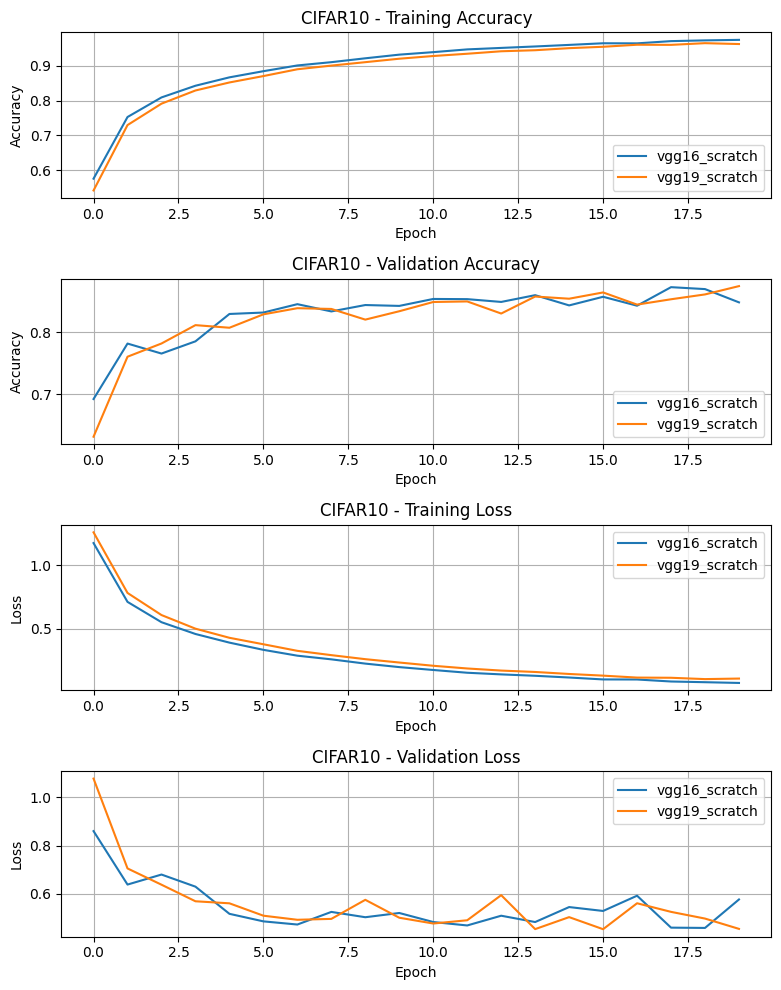

Dataset Model    Mode  Final Train Acc  Final Test Acc  Final Test Loss  Best Epoch  Best Test Acc
CIFAR10 vgg16 scratch            0.975          0.8478           0.5774          18         0.8723
CIFAR10 vgg19 scratch            0.963          0.8740           0.4560          20         0.8740


In [6]:
epochs = 20
dataset_name = "cifar10"
metrics = load_dataset_metrics(dataset_name)
plot_metrics(metrics, dataset_name, range(epochs))

# summary_df = create_summary_table(dataset_name=dataset_name, architectures)
summary_df = create_summary_table(dataset_name=dataset_name, 
                                  architectures=architectures,
                                 modes=modes,
                                 results_dir=results_dir)
print(summary_df.to_string(index=False))